In [1]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch, seaborn as sns
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from HMCfunctions import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [15]:
n_in = 1
n_h1 = 20
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))
nn_model.apply(init_normal);

* Total number of parameters:

In [16]:
print(sum(p.numel() for p in nn_model.parameters()))

82


#### Generate some random data:

In [5]:
error_sigma = 1e-1
nobs = 1_000
xtrue = torch.rand(nobs, n_in, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, n_out))
ytrue[:,0] = list(abs(xvals)*np.cos(4*np.pi*xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(2*np.pi*xvals))
ytrue = 3*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()

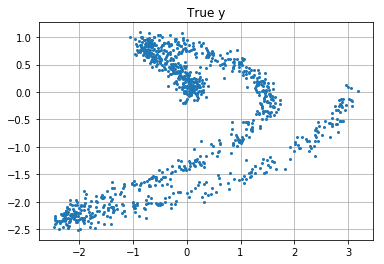

In [8]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

###  HMC

In [6]:
prior_sigma = 1
my_model = model(x, y, prior_sigma, error_sigma, nn_model)
my_model.init_normal()
my_model.update_grad()

In [9]:
T = 500
int_time = 1e1
delta_leapfrog = 1e-2
n_leapfrog = int(int_time/delta_leapfrog)
M = torch.eye(my_model.n_params())
hmc = HMC(my_model, M, n_leapfrog, delta_leapfrog, T)
hmc.minlf = 20

In [10]:
hmc.run_HMC()

iter     50/500 after 0.13 min | accept_rate 0.040 | MSE loss 1.394 | stepsize 0.001 | nleapfrog 20
iter    100/500 after 0.16 min | accept_rate 0.070 | MSE loss 1.383 | stepsize 0.001 | nleapfrog 20
iter    150/500 after 0.19 min | accept_rate 0.053 | MSE loss 1.380 | stepsize 0.001 | nleapfrog 20
iter    200/500 after 0.23 min | accept_rate 0.065 | MSE loss 1.375 | stepsize 0.001 | nleapfrog 20
iter    250/500 after 0.27 min | accept_rate 0.052 | MSE loss 1.376 | stepsize 0.001 | nleapfrog 20
iter    300/500 after 0.31 min | accept_rate 0.043 | MSE loss 1.377 | stepsize 0.001 | nleapfrog 20
iter    350/500 after 0.36 min | accept_rate 0.043 | MSE loss 1.376 | stepsize 0.001 | nleapfrog 20
iter    400/500 after 0.42 min | accept_rate 0.037 | MSE loss 1.376 | stepsize 0.001 | nleapfrog 20
iter    450/500 after 0.47 min | accept_rate 0.036 | MSE loss 1.376 | stepsize 0.001 | nleapfrog 20
iter    500/500 after 0.52 min | accept_rate 0.036 | MSE loss 1.374 | stepsize 0.001 | nleapfrog 20


#### ESS's:

In [11]:
ESS = [int(T/gewer_estimate_IAT(hmc.chain[:,i].data.numpy())) for i in range(np.shape(hmc.chain)[1])]
print("ESS: min, median, mean, max", (min(ESS), np.mean(ESS), np.median(ESS), max(ESS)))

ESS: min, median, mean, max (3, 322.9324853228963, 317.0, 928)


In [12]:
print("Mean ESS: theta %f, x %f"
      (np.mean(ESS[:sum(p.numel() for p in nn_model.parameters())]),
       np.mean(ESS[sum(p.numel() for p in nn_model.parameters())::])))

Mean ESS: theta %f, x %f (8.636363636363637, 329.847)


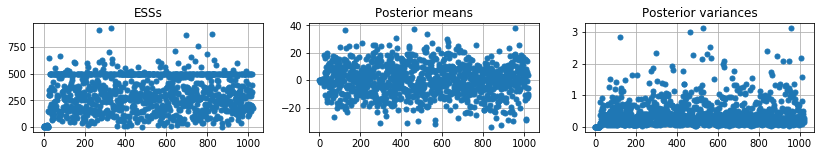

In [13]:
ms = 5
plt.figure(figsize=(14,2))
plt.rcParams['axes.grid'] = True
plt.subplot(131)
plt.plot(ESS, 'o', markersize=ms)
plt.title("ESSs")
plt.subplot(132)
plt.plot(torch.mean(hmc.chain,0).data.numpy(), 'o', markersize=ms)
plt.title("Posterior means")
plt.subplot(133)
plt.plot(torch.var(hmc.chain,0).data.numpy(), 'o', markersize=ms)
plt.title("Posterior variances");

### Gradient descent:

In [43]:
x = torch.randn(np.shape(xtrue), requires_grad=True)

In [52]:
niter = 10**5
lr = 1e-1
rho = 1+2e-4

kappa = 0
delta = 1+1e-1

lss = np.ones(11)

start = time()
for i in range(niter) :
    loss = nn.MSELoss()(nn_model(x), ytrue)
    loss.backward(retain_graph=True)
    lr /= rho
    kappa /= delta
    if (i+1)%(niter/10) == 0 :
        c = int((i+1)/(niter/10))
        lss[c] = loss.data
        print("loss = %f after %6d/%d iterations in %.1f sec" % (loss, i+1, niter, time()-start))
        if (lss[c-1]-lss[c] < 1e-1) & (lss[c] > 1e-2) :
            kappa = 1e-2
        
    for param in nn_model.parameters() :
        param.data -= lr*param.grad.data + kappa*torch.randn(np.shape(param))
        param.grad.data.zero_()
    x.data -= lr*x.grad.data + kappa*torch.randn(np.shape(x))
    x.grad.data.zero_()

loss = 0.790367 after  10000/100000 iterations in 42.3 sec
loss = 0.788988 after  20000/100000 iterations in 87.4 sec
loss = 0.790717 after  30000/100000 iterations in 127.5 sec
loss = 0.798354 after  40000/100000 iterations in 167.4 sec
loss = 0.924379 after  50000/100000 iterations in 210.8 sec
loss = 1.082459 after  60000/100000 iterations in 252.4 sec
loss = 1.239044 after  70000/100000 iterations in 295.7 sec
loss = 1.393133 after  80000/100000 iterations in 341.2 sec
loss = 1.444309 after  90000/100000 iterations in 388.4 sec


IndexError: index 10 is out of bounds for axis 0 with size 10

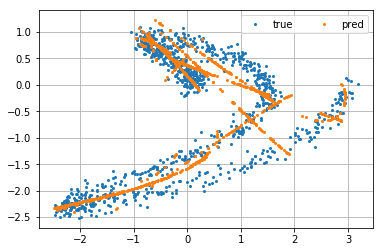

In [20]:
ypred = nn_model(x)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.plot(list(ypred[:,0]), list(ypred[:,1]), 'o', markersize=2, label="pred")
plt.legend(ncol=2)
plt.grid(True)